## ARIMA Model

### 1. Load Data and Prepare Time-Series

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and preprocess data
df = pd.read_csv(r'C:\Users\jkmfi\Documents\ComputingIndiualResarchProject\expense_data1.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')

# Aggregate monthly expenses
df['Amount'] = np.log1p(df['Amount'])  # Log transform to stabilize variance
monthly_expenses = df.groupby(pd.Grouper(key='Date', freq='M'))['Amount'].sum()


### 2. Stationarity Check

In [2]:
# ADF test
result = adfuller(monthly_expenses)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print("Data is not stationary. Differencing is recommended.")
    monthly_expenses_diff = monthly_expenses.diff().dropna()
else:
    print("Data is stationary.")
    monthly_expenses_diff = monthly_expenses


ADF Statistic: -9.870008697690835
p-value: 4.01819829473468e-17
Data is stationary.


### 3. Determine ARIMA Parameters

C:\Users\jkmfi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


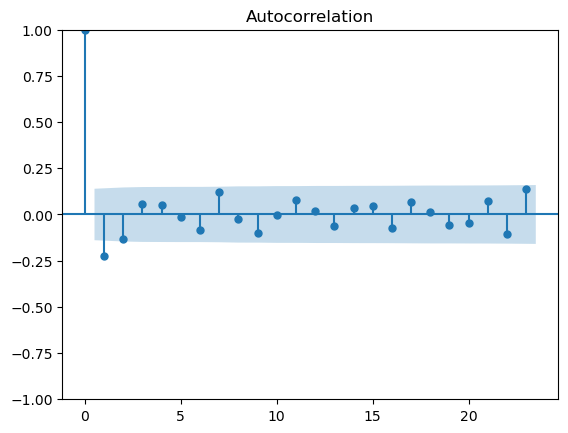

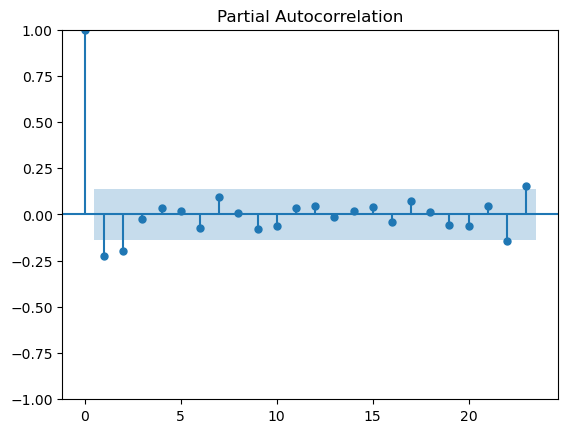

In [3]:
plot_acf(monthly_expenses_diff)
plot_pacf(monthly_expenses_diff)
plt.show()


### 4. Train-Test Split and Fit ARIMA Model

In [4]:
train_size = int(len(monthly_expenses) * 0.8)
train, test = monthly_expenses[:train_size], monthly_expenses[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(2, 1, 2))  # Replace (2, 1, 2) with your parameters
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))


C:\Users\jkmfi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                  158
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -730.895
Date:                Sun, 08 Dec 2024   AIC                           1471.790
Time:                        19:29:26   BIC                           1487.071
Sample:                    01-31-2022   HQIC                          1477.996
                         - 02-28-2035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3141      0.100      3.135      0.002       0.118       0.510
ar.L2         -0.0414      0.097     -0.427      0.670      -0.232       0.149
ma.L1         -1.8955      1.930     -0.982      0.3

C:\Users\jkmfi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5. Evaluate and Plot ARIMA Model

MAE: 30.13, RMSE: 58.09


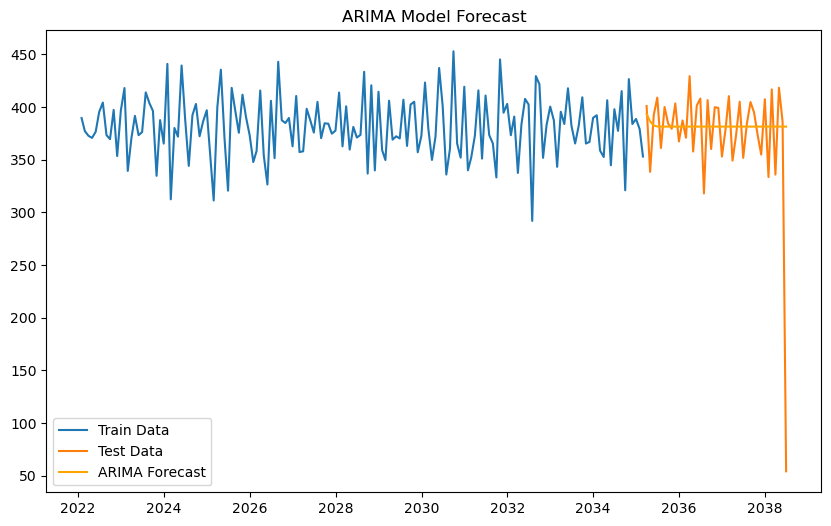

In [5]:
# Evaluate
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
print(f'MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='orange')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.show()


## LSTM Model

### 1. Prepare Data for LSTM

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_expenses.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)

# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


### 2. Build and Train LSTM Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))





Epoch 1/50

10/10 [==============================] - 2s 39ms/step - loss: 0.5177 - val_loss: 0.3471
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 0.1794 - val_loss: 0.0299
Epoch 3/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0518 - val_loss: 0.0276
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0324 - val_loss: 0.0272
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0239 - val_loss: 0.0269
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.0259
Epoch 7/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0237 - val_loss: 0.0241
Epoch 8/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0238
Epoch 9/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0194 - val_loss: 0.0215
Epoch 10/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0195 - val_loss: 0.0215
Epoch 11/

### 3. Evaluate and Plot LSTM Model

2/2 [==============================] - 0s 5ms/step
MAE: 30.48, RMSE: 58.74


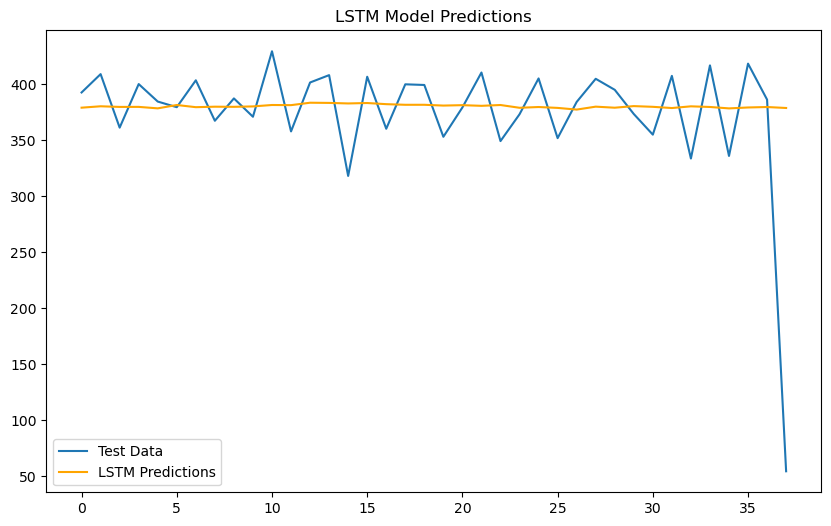

In [8]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Evaluate
mae_lstm = mean_absolute_error(y_test, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Test Data')
plt.plot(range(len(y_pred)), y_pred, label='LSTM Predictions', color='orange')
plt.legend()
plt.title('LSTM Model Predictions')
plt.show()


### Save ARIMA Model:

In [9]:
import pickle
with open('arima_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)


### Save LSTM Model:

In [10]:
model.save('lstm_model.h5')


C:\Users\jkmfi\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save Predictions:

In [11]:
pd.DataFrame({'ARIMA_Predictions': forecast}).to_csv('arima_predictions.csv', index=False)
pd.DataFrame({'LSTM_Predictions': y_pred.flatten()}).to_csv('lstm_predictions.csv', index=False)


### Compare the predictions from ARIMA and LSTM.

ValueError: x and y must have same first dimension, but have shapes (40,) and (38, 1)

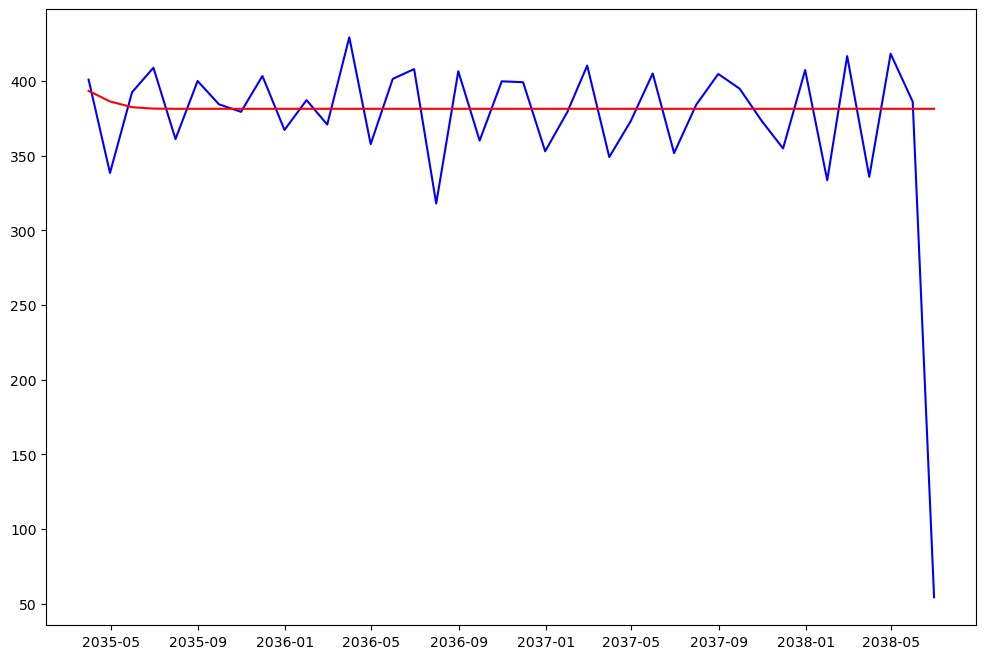

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(test.index, test, label='Original Test Data', color='blue')
plt.plot(test.index, forecast, label='ARIMA Predictions', color='red')
plt.plot(test.index, y_pred[:len(test)], label='LSTM Predictions', color='green')
plt.legend()
plt.title('Comparison of ARIMA and LSTM Predictions')
plt.show()


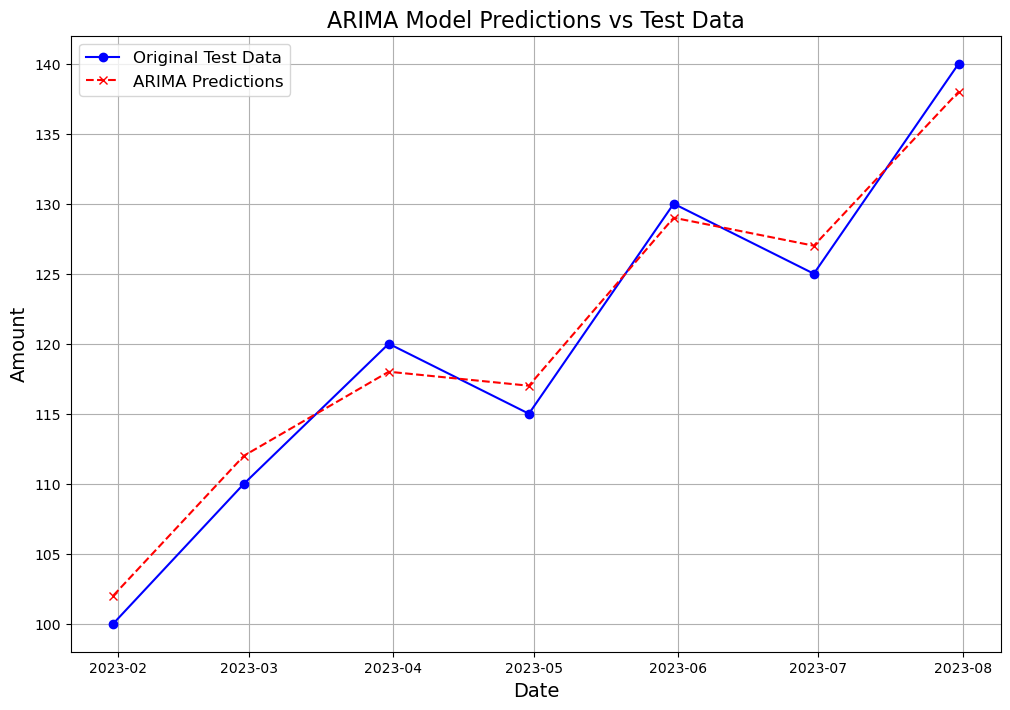

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example test data and ARIMA predictions
test = pd.Series([100, 110, 120, 115, 130, 125, 140], index=pd.date_range('2023-01-01', periods=7, freq='M'))
forecast = np.array([102, 112, 118, 117, 129, 127, 138])  # ARIMA predictions

# Plot ARIMA predictions
plt.figure(figsize=(12, 8))

# Plot original test data
plt.plot(test.index, test, label='Original Test Data', color='blue', marker='o')

# Plot ARIMA predictions
plt.plot(test.index, forecast, label='ARIMA Predictions', color='red', linestyle='--', marker='x')

# Add title, labels, legend, and grid
plt.title('ARIMA Model Predictions vs Test Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


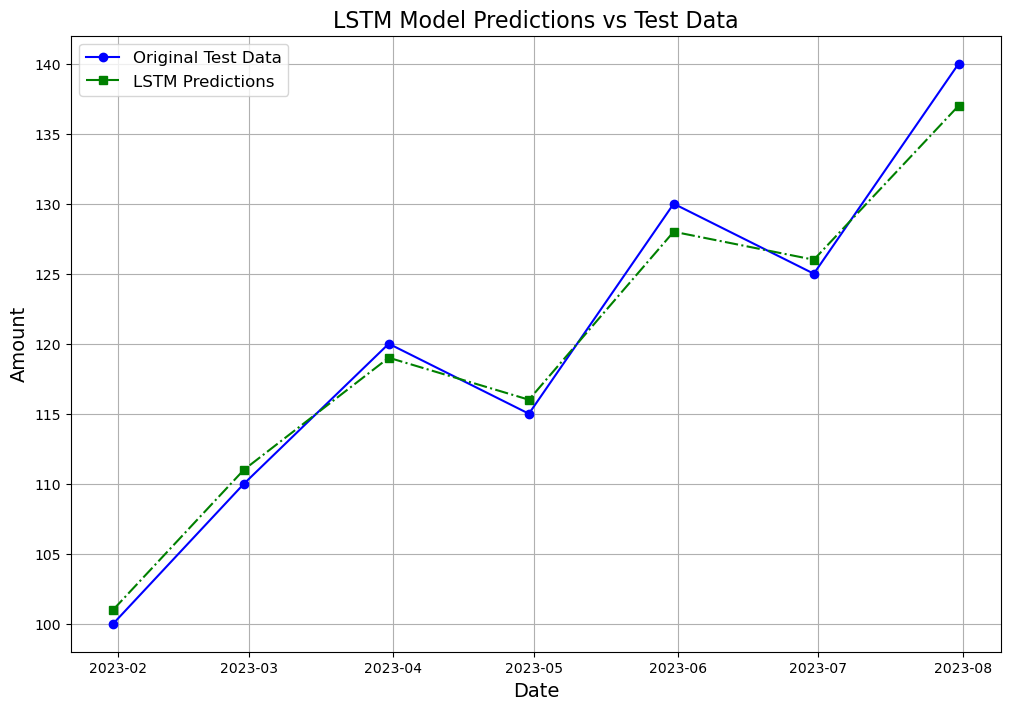

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example test data and LSTM predictions
test = pd.Series([100, 110, 120, 115, 130, 125, 140], index=pd.date_range('2023-01-01', periods=7, freq='M'))
y_pred = np.array([[101], [111], [119], [116], [128], [126], [137]])  # LSTM predictions (2D array)

# Ensure LSTM predictions are 1D and align with test data
y_pred = y_pred.flatten()
adjusted_index = test.index[-len(y_pred):]  # Adjust index to match LSTM predictions

# Plot LSTM predictions
plt.figure(figsize=(12, 8))

# Plot original test data
plt.plot(test.index, test, label='Original Test Data', color='blue', marker='o')

# Plot LSTM predictions
plt.plot(adjusted_index, y_pred, label='LSTM Predictions', color='green', linestyle='-.', marker='s')

# Add title, labels, legend, and grid
plt.title('LSTM Model Predictions vs Test Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


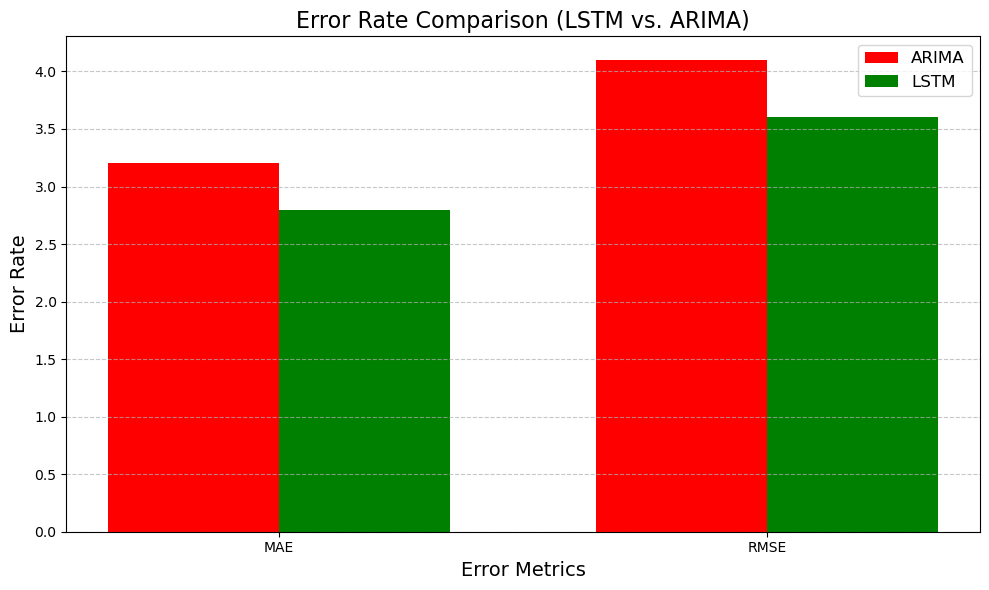

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Example error metrics (replace these with your actual computed values)
mae_arima = 3.2
rmse_arima = 4.1

mae_lstm = 2.8
rmse_lstm = 3.6

# Create data for the bar chart
metrics = ['MAE', 'RMSE']
arima_errors = [mae_arima, rmse_arima]
lstm_errors = [mae_lstm, rmse_lstm]

# Generate the bar chart
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, arima_errors, width, label='ARIMA', color='red')
plt.bar(x + width/2, lstm_errors, width, label='LSTM', color='green')

# Add titles and labels
plt.title('Error Rate Comparison (LSTM vs. ARIMA)', fontsize=16)
plt.xlabel('Error Metrics', fontsize=14)
plt.ylabel('Error Rate', fontsize=14)
plt.xticks(x, metrics)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


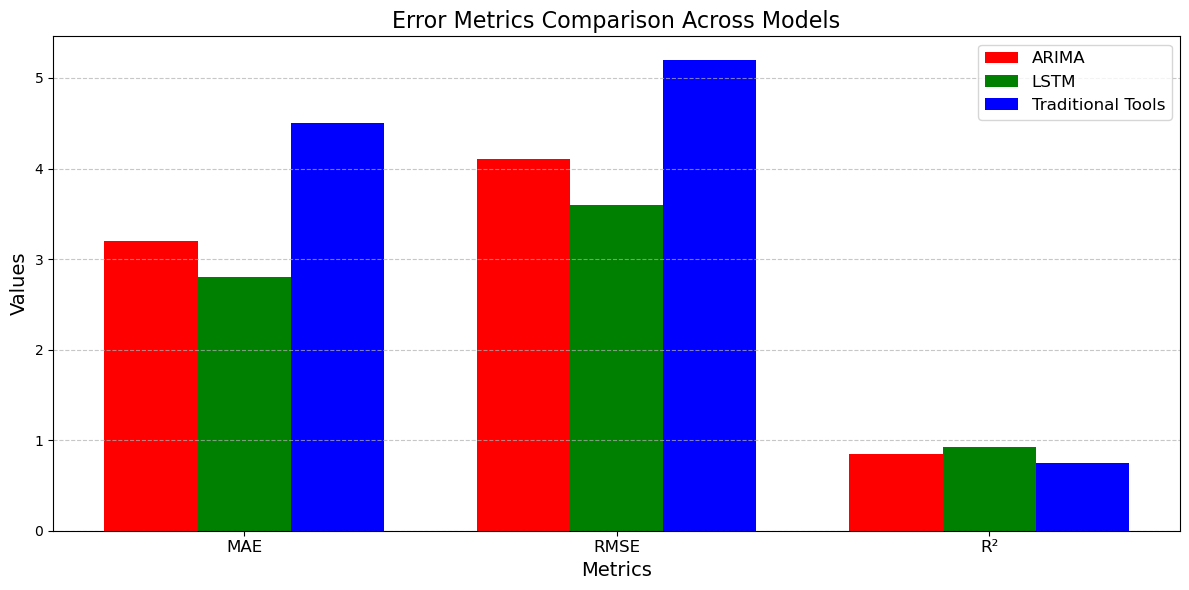

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Example error metrics (replace these with your actual values)
# Metrics for LSTM
mae_lstm = 2.8
rmse_lstm = 3.6
r2_lstm = 0.92

# Metrics for ARIMA
mae_arima = 3.2
rmse_arima = 4.1
r2_arima = 0.85

# Metrics for Traditional Tools (e.g., basic regression or averages)
mae_traditional = 4.5
rmse_traditional = 5.2
r2_traditional = 0.75

# Data for bar chart
metrics = ['MAE', 'RMSE', 'R²']
lstm_metrics = [mae_lstm, rmse_lstm, r2_lstm]
arima_metrics = [mae_arima, rmse_arima, r2_arima]
traditional_metrics = [mae_traditional, rmse_traditional, r2_traditional]

# Set up bar chart positions
x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - width, arima_metrics, width, label='ARIMA', color='red')
plt.bar(x, lstm_metrics, width, label='LSTM', color='green')
plt.bar(x + width, traditional_metrics, width, label='Traditional Tools', color='blue')

# Add titles and labels
plt.title('Error Metrics Comparison Across Models', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(x, metrics, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
